In [720]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import altair as alt
import gif

from IPython.display import IFrame 

import h5py as h5
import os

import meep as mp
import meep.mpb as mpb

import meep_mod.mod as mod 

# 一维光子晶体能带结构

在这个例子中，我们会接入meep Mode求解器，分析一维光子晶体模型的bandmap。\
光子晶体参数参考 *Quan, Q., & Loncar, M. (2011). Deterministic design of wavelength scale, ultra-high Q photonic crystal nanobeam cavities. Optics express, 19(19), 18529-18542.*

该例子模型脚本在 ./sample/bandmap_of_1DPhotonicCrystal，结构如下：
> bandmap_of_1DPhotonicCrystal

>> model *# 定义模型、研究脚本* 
>>> \_\_init\_\_.py \
>>> model.py \
>>> modestudy_bandmap_.py

>> data *# 输出保存位置*
>>> ... 

>> bandmap.py

>> scan_bandmap.py

## 能带图

In [652]:
# 定义一些数据可视化函数

def plot_bandmap(ks, frqs, a, ylim=None, title=None, mark='+-'):
    light_cone_k = np.arange(0, 0.5, 0.01)
    light_cone_frq_top = np.ones(len(light_cone_k))*1.5
    light_cone_frq_air = light_cone_k/a
    
    fig, ax = plt.subplots(1, 1)
    ax.set_aspect(1./1)
    ax.grid(True)
    ax.set_xlabel('kx / π/a')
    ax.set_ylabel('f / c')
    if title:
        ax.set_title(title)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlim([0, 0.5])
    
    for i in range(len(frqs[0])):
        ax.plot(ks, np.real(frqs[:, i]), mark)
        
    ax.plot(light_cone_k, light_cone_frq_air, 'blue')
    plt.fill_between(light_cone_k, light_cone_frq_air, light_cone_frq_top)
    plt.show()
    
def plot_dielectirc(eps, title=None):
    fig = plt.figure(figsize=(4,2))
    axs = fig.subplots(1, 3)
    for i, a in enumerate(['x','y','z']):
        ax = axs[i]
        mod.plot_data_eps(fig, ax, mod.center_slice(eps, ax=a), alpha=1)
    if title:
        ax.set_title(title)
    plt.show()
    
def plot_field(field, title=None):
    fig = plt.figure(figsize=(1,2))
    ax = fig.subplots(1, 1)
    mod.plot_data_field(fig, ax, mod.center_slice(field, ax='z'), alpha=1)
    ax.axis('off')
    if title:
        ax.set_title(title)
    plt.show()

首先检查 model/model.py 内的参数，可以直接运行 model/model.py 以查看几何参数。\
在该例子中我们使用resolution=20, n_k=15 以获得较快的模拟速度，实际情况可以增加resolution与kpoint个数

运行 bandmap.py 计算一个模型的能带，这里计算了其 TE & yOdd 模式 以匹配我们需要的输入模式 \
```python bandmap.py``` / ```mpirun -np [n] python bandmap.py```

几何结构 & 能带图如下：

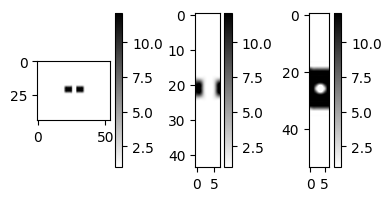

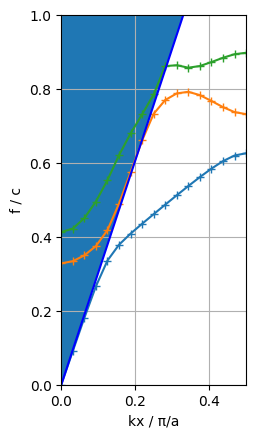

In [653]:
study_dirname = "sample/bandmap_of_1DPhotonicCrystal/data/Modestudy_2023-09-24_16-00-20"
filename = study_dirname + "/result/model.h5"
result = mod.read_h5(filename)

freqs = result['Mode_bandmap_']['all_freqs']
kxs = [k['x'] for k in result['Mode_bandmap_']['k_points']]
a = result['a']

eps = result['Mode_bandmap_']['eps']
plot_dielectirc(eps)

plot_bandmap(kxs, freqs, a=a, ylim=[0, 1])

能带图不同位置的模式电场：

光锥内为对外耗散模式 \
第0阶模式电场集中在介质中 \
第1阶模式电场集中在孔（空气）中

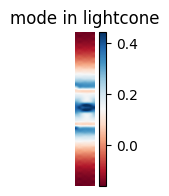

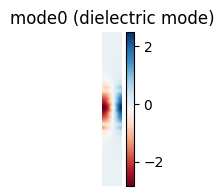

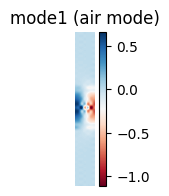

In [416]:
k,b = 2,2
filename = study_dirname + '/runtime/' + "bandfield-e.k%02d.b%02d.zevenyodd.h5" % (k,b)
with h5.File(filename,"r") as f:
    field = f['y.r'][:]
    plot_field(field, title = 'mode in lightcone')
    
k,b = 16,1
filename = study_dirname + '/runtime/' + "bandfield-e.k%02d.b%02d.zevenyodd.h5" % (k,b)
with h5.File(filename,"r") as f:
    field = f['y.r'][:]
    plot_field(field, title = 'mode0 (dielectric mode)')

k,b = 16,2
filename = study_dirname + '/runtime/' + "bandfield-e.k%02d.b%02d.zevenyodd.h5" % (k,b)
with h5.File(filename,"r") as f:
    field = f['y.r'][:]
    plot_field(field, title = 'mode1 (air mode)')

## 反射率

能带图中两个导带中间的频率即为光子禁带，这些频率的光场无法在光子晶体中稳定传播($e^{-ik_x x}$)，而是以倏逝场的形式被反射($e^{-\kappa_x x}$)

对处在禁带边缘中的光场频率，可以利用能带方程在复数平面上的连续性估计其$\kappa_x$的大小。\
$f = f(k+i\kappa)$, $\kappa << k$\
$\Delta f = -\frac{1}{2}\partial^2_k f(k)\kappa^2 $, $(\partial_k f(k)=0 @ bandedge)$

利用上面的能带，估计$f=0.66$($\lambda=1515nm$)：

In [418]:
freq0 = 0.645
band = 0
if freq0 - freqs[-1, band] > 0:
    kappa = np.sqrt((kxs[-1] - kxs[-2]) ** 2 / (freqs[-1, band] - freqs[-2, band]) * (freq0 - freqs[-1, band]))
else:
    kappa = 0
kappa

0.054877342245164724

## 参数扫描

扫描 ff 参数（控制孔洞大小）

运行 scan_bandmap.py \
```python scan_bandmap.py``` / ```mpirun -np [n] python scan_bandmap.py```

参数扫描生成一系列文件

In [508]:
scan_dirname = "sample/bandmap_of_1DPhotonicCrystal/data/scan_Modestudy_2023-09-24_17-45-36"
ch_dirnames = os.listdir(scan_dirname)
df_files = pd.DataFrame({
    'ch_dir': ch_dirnames, 
})
df_files.index = list(map(lambda s: int(s.split('_')[-1]), df_files['ch_dir']))
df_files.sort_index(inplace=True)
df_files

,ch_dir
0,Modestudy_2023-09-24_17-45-36_0
1,Modestudy_2023-09-24_17-45-37_1
2,Modestudy_2023-09-24_17-45-39_2
3,Modestudy_2023-09-24_17-45-41_3
4,Modestudy_2023-09-24_17-45-43_4
5,Modestudy_2023-09-24_17-45-44_5
6,Modestudy_2023-09-24_17-45-47_6
7,Modestudy_2023-09-24_17-45-49_7
8,Modestudy_2023-09-24_17-45-50_8
9,Modestudy_2023-09-24_17-45-52_9


不同参数的能带图如下：

In [728]:
freqs = np.array([])
bands = np.array([])
kxs = np.array([])
a = np.array([])
ffs = np.array([])
for ch_dirname in df_files['ch_dir']:
    filename = scan_dirname+'/'+ch_dirname+"/result/model.h5"
    result = mod.read_h5(filename)
    all_freqs = result['Mode_bandmap_']['all_freqs']
    k_points = result['Mode_bandmap_']['k_points']
    for b in range(all_freqs.shape[1]):
        freqs = np.hstack([freqs, all_freqs[:,b]])
        bands =np.hstack([bands, np.ones_like(all_freqs[:,b])*b])
        kxs =np.hstack([kxs, [k['x'] for k in k_points]])
        a =np.hstack([a, np.ones_like(all_freqs[:,b])*result['a']])
        ffs =np.hstack([ffs, np.ones_like(all_freqs[:,b])*result['ff']])
        
df_bandmaps = pd.DataFrame({
    'freq': freqs,
    'band': bands,
    'kx': kxs,
    'a': a,
    'ff': ffs,
})

alt_bandmaps = alt.Chart(df_bandmaps).mark_line().encode(
    x=alt.X('kx',scale=alt.Scale(zero=False),title='kx/(pi/a)'),
    y=alt.Y('freq',scale=alt.Scale(zero=False)),
    shape = alt.Shape('band:N'),
    color=alt.Color('ff:O'),
    tooltip=['a','ff', 'band', 'kx', 'freq'],
    detail=['ff:O','band:N'],
).properties(title='Bandmaps')

alt_bandmaps.save('sample/bandmap_of_1DPhotonicCrystal/bandmaps.html')
alt_bandmaps

alt.Chart(...)

不同参数的禁带边界：

In [729]:
a_set = set(df_bandmaps['a'])
ff_set = set(df_bandmaps['ff'])
kx_set = set(df_bandmaps['kx'])

df_bandedges = df_bandmaps[df_bandmaps['kx']==max(kx_set)]

alt_bandedges = alt.Chart(df_bandedges).mark_point(shape='circle').encode(
    x=alt.X('ff',scale=alt.Scale(zero=False)),
    y=alt.Y('freq',scale=alt.Scale(zero=False)),
    color=alt.Color('band:N'),
    size=alt.value(100),
    tooltip=['a','ff', 'band', 'kx', 'freq']
).properties(title='Bandedges ')


alt_bandedges.save('sample/bandmap_of_1DPhotonicCrystal/bandedges.html')
alt_bandedges

alt.Chart(...)

不同参数对 $f=0.66$($\lambda=1515nm$) 的 kappa：

In [730]:
def calc_kappa(freq0, kxs, freqs):
    if freq0 - freqs.iloc[-1] > 0:
        kappa = np.sqrt((kxs.iloc[-1] - kxs.iloc[-2]) ** 2 / (freqs.iloc[-1] - freqs.iloc[-2]) * (freq0 - freqs.iloc[-1]))
    else:
        kappa = 0
    return kappa

def bandmaps2kappa(freq0, band, df_bandmaps):
    df = df_bandmaps
    return list(map(lambda ff: calc_kappa(freq0, 
                                          df[(df.ff==ff) & (df.band==band)].kx,
                                          df[(df.ff==ff) & (df.band==band)].freq,
                                         ), ff_set))

df_kappa0 = pd.DataFrame({
    "ff": list(ff_set), 
    "kappa": bandmaps2kappa(0.66, 0, df_bandmaps),
})

alt_kappa0 = alt.Chart(df_kappa0).mark_point(shape='circle').encode(
    x=alt.X('ff',scale=alt.Scale(zero=False)),
    y=alt.Y('kappa',scale=alt.Scale(zero=False),title='kappa/(pi/a)'),
    size=alt.value(100),
    tooltip=['ff', 'kappa']
).properties(title='kappa ')

alt_kappa0.save('sample/bandmap_of_1DPhotonicCrystal/kappa0.html')
alt_kappa0

alt.Chart(...)

# 一维光子晶体（布拉格反射镜）的反射/透射

在这个例子中，我们会接入meep FDTD求解器，分析一维光子晶体）的反射/透射。光子晶体参数沿用上一个例子。

该例子模型脚本在 ./sample/reflection_of_1DBraggMirror，结构如下：
> reflection_of_1DBraggMirror

>> model *# 定义模型、几何、研究脚本* 
>>> \_\_init\_\_.py \
>>> model.py \
>>> geo_1DBraggMirror_.py \
>>> fdtdstudy_flux_.py

>> data *# 输出保存位置*
>>> ... 

>> reflection.py

首先检查 model/model.py 内的参数，可以直接运行 model/model.py 以查看几何参数。\
在该例子中我们使用resolution=20 以获得较快的模拟速度，实际情况可以增加resolution \
作为验证，设置 ff=0.1（上面的例子中得到的$\kappa$最大值）

model结构如下（source, monitor 分别以 红色、蓝色 表示）：\
<img src='sample/reflection_of_1DBraggMirror/model_x.png' width=300>
<img src='sample/reflection_of_1DBraggMirror/model_y.png' width=300>
<img src='sample/reflection_of_1DBraggMirror/model_z.png' width=300>

运行 reflection.py 以模拟一个模型的时间域透射/反射，这里限定了 zMirror & zMirror 对称性 以在匹配需要的输入模式下加快计算速度 \
```python reflection.py``` / ```mpirun -np [n] python reflection.py```

将 outputfield 参数设置成 True 可保存电场的时间演化，并用下面的脚本生成gif：\
<img src='sample/reflection_of_1DBraggMirror/reflection.gif' width=800>

In [713]:
study_dirname = "sample/reflection_of_1DBraggMirror/data/FDTDstudy_2023-09-25_14-47-08"

@gif.frame
def plot_gif(i):
    filename = study_dirname + "/runtime/field-e-%06d.00.h5" % i
    with h5.File(filename,"r") as f:
        # print(f.keys())
        field = f['ey'][:]
        
        fig = plt.figure(figsize=(10,2))
        ax = fig.subplots(1, 1)
        im = ax.imshow(np.rot90(mod.center_slice(field, ax='z')), interpolation='spline36', cmap='RdBu')
        fig.colorbar(im, ax=ax).mappable.set_clim(-5,5)
        ax.axis('off')

frames = []
for i in range(1, 117):
    frames.append(plot_gif(i))

gif.save(frames, 'sample/reflection_of_1DBraggMirror/reflection.gif', duration=0.5)

流量探测器整列得到的 时间-总通量 如下，取时间微分即得到 透射流量

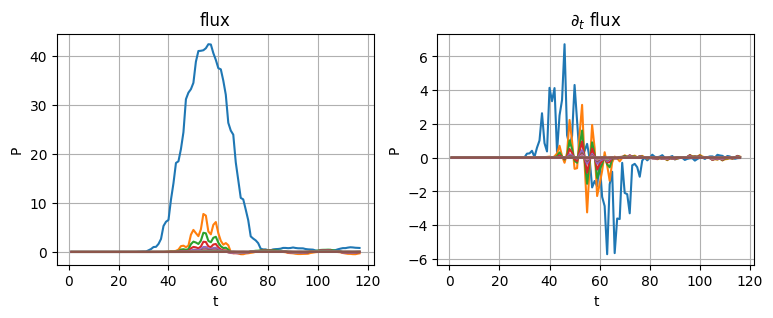

In [715]:
study_dirname = "sample/reflection_of_1DBraggMirror/data/FDTDstudy_2023-09-25_13-30-19"
filename = study_dirname + "/result/model.h5"
result = mod.read_h5(filename)

fluxes = result['FDTD_flux_']['fluxes_history']
freqs = result['FDTD_flux_']['fluxes_freq']
t = result['FDTD_flux_']['t']

dfluxes_dt = fluxes[:,1:,1]-fluxes[:,:-1,1]

fig = plt.figure(figsize=[9,3])
axs = fig.subplots(1,2)
ax = axs[0]
ax.plot(t, fluxes[:,:,1].transpose())
ax.set_title('flux')
ax.set_xlabel('t')
ax.set_ylabel('P')
ax.grid(True)
ax = axs[1]
ax.plot(t[:-1], dfluxes_dt.transpose())
ax.set_title('$\partial_t$ flux')
ax.set_xlabel('t')
ax.set_ylabel('P')
ax.grid(True)
plt.show()

在对数坐标下画出 反射镜个数—透射 关系

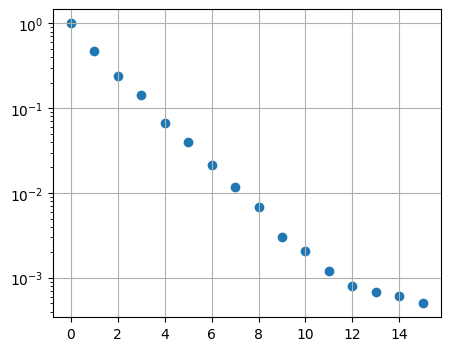

In [716]:
T = np.max(dfluxes_dt, axis=1)
T = T/T.max()
n_mirror = np.arange(len(max_fluxes))

fig = plt.figure(figsize=[5,4])
ax = fig.subplots(1,1)
ax.scatter(n_mirror, T)
ax.set_yscale('log')
ax.grid(True)
plt.show()

拟合得到 $T(n) = e^{-0.598n}$ \
由 $E(x) = e^{-\kappa x}$, $x=na$ \
得到 $\kappa = \frac{0.598}{2 \pi} \frac{\pi}{a} = 0.093 \frac{\pi}{a}$ \
上一个例子中用能带图估计的 $\kappa = 0.074 \frac{\pi}{a}$

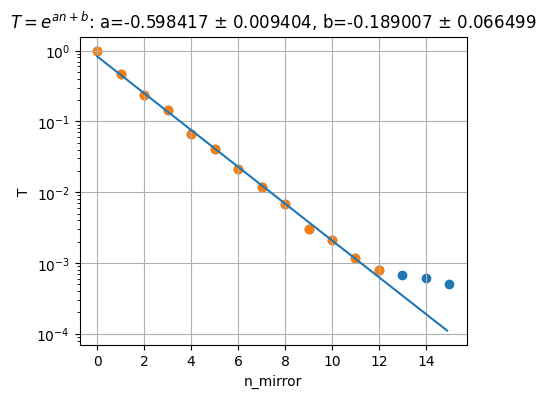

In [717]:
def linear(x, a, b):
    return a*x + b

select_n = (0,13)
popt, pcov = curve_fit(linear, n_mirror[select_n[0]:select_n[1]], np.log(T[select_n[0]:select_n[1]]))
perr = np.sqrt(np.diag(pcov))

fit_x = np.arange(0,15,0.1)
fit_y = np.exp(linear(fit_x, *popt))

fig = plt.figure(figsize=[5,4])
ax = fig.subplots(1,1)
ax.scatter(n_mirror, T)
ax.scatter(n_mirror[select_n[0]:select_n[1]], T[select_n[0]:select_n[1]])
ax.plot(fit_x, fit_y)
ax.set_yscale('log')
ax.grid(True)
ax.set_title("$T=e^{an+b}$: a=%f $\pm$ %f, b=%f $\pm$ %f" % (popt[0], perr[0], popt[1], perr[1]))
ax.set_xlabel('n_mirror')
ax.set_ylabel('T')
plt.show()